モデルのトレーニングと評価を開始します
モデルのテストを開始します
ループ回数: 1


TypeError: forward() missing 3 required positional arguments: 'y_train', 'mask_x_train', and 'mask_y_train'

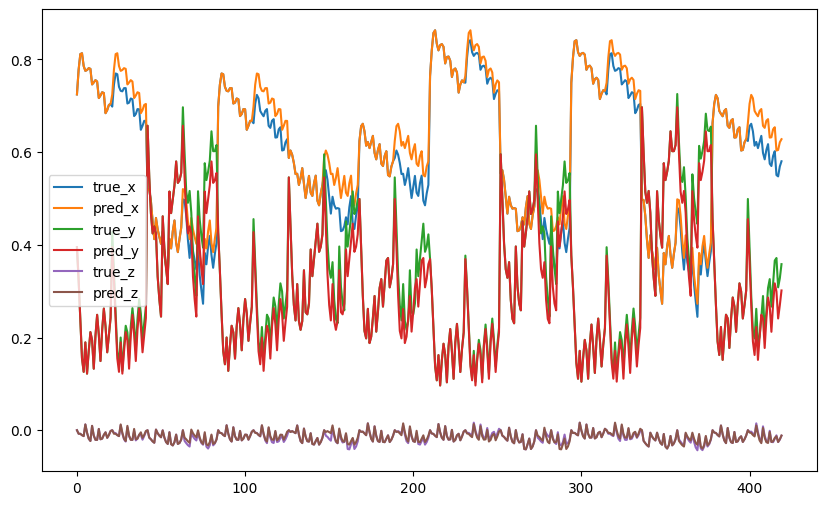

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import random
import time
import cv2

# デバイスの設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# フラットな手の座標をMediaPipe Handランドマークに変換する関数
def flatten_to_landmarks(coordinates):
    landmarks = []
    for i in range(0, len(coordinates), 3):
        landmarks.append((coordinates[i], coordinates[i + 1], coordinates[i + 2]))
    return landmarks

# データの読み込みと前処理
def preprocess_data(csv_path, n_seq, num_joints):
    df = pd.read_csv(csv_path)
    x_data = []
    y_data = []

    for i in range(len(df) - n_seq):
        x_sequence = df.iloc[i:i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values
        x_data.append(x_sequence)

        y_sequence = df.iloc[i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values
        y_data.append(y_sequence)

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return x_data, y_data

# じゃんけんの手のラベル
janken_labels = {0: 'チョキ', 1: 'グー', 2: 'パー'}

# DataLoaderの使用
def create_dataloader(x_train, y_train, batch_size):
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

# Transformerの定義
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, d_input, d_output, dim_feedforward=512, dropout=0.1, nhead=8):
        super(Transformer, self).__init__()
        self.token_embedding_x_train = TokenEmbedding(d_input, d_model)
        self.token_embedding_y_train = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation='gelu')
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers, norm=encoder_norm)
        decoder_layer = TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation='gelu')
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers, norm=decoder_norm)
        self.output = nn.Linear(d_model, d_output)

    def forward(self, x_train, y_train, mask_x_train, mask_y_train):
        embedding_x_train = self.positional_encoding(self.token_embedding_x_train(x_train))
        memory = self.transformer_encoder(embedding_x_train, mask_x_train)
        embedding_y_train = self.positional_encoding(self.token_embedding_y_train(y_train))
        outs = self.transformer_decoder(embedding_y_train, memory, mask_y_train)
        output = self.output(outs)
        return output

    def encode(self, x_train, mask_x_train):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_x_train(x_train)), mask_x_train)

    def decode(self, y_train, memory, mask_y_train):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_y_train(y_train)), memory, mask_y_train)

# マスクの定義
def create_mask(x_train, y_train):
    seq_len_x_train = x_train.shape[1]
    seq_len_y_train = y_train.shape[1]
    mask_y_train = generate_square_subsequent_mask(seq_len_y_train).to(device)
    mask_x_train = generate_square_subsequent_mask(seq_len_x_train).to(device)
    return mask_x_train, mask_y_train

def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask

# 訓練、評価の処理を定義
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for x_train, y_train in data_provider:
        x_train = x_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # 次元のチェックと拡張
        if x_train.dim() == 2:
            x_train = x_train.unsqueeze(1)
        if y_train.dim() == 2:
            y_train = y_train.unsqueeze(1)
        
        input_y_train = torch.cat((x_train[:, -1:, :], y_train[:, :-1, :]), dim=1)
        mask_x_train, mask_y_train = create_mask(x_train, input_y_train)
        output = model(x_train=x_train, y_train=input_y_train, mask_x_train=mask_x_train, mask_y_train=mask_y_train)
        optimizer.zero_grad()
        loss = criterion(output, y_train)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
    return np.average(total_loss)

def evaluate(flag, model, data_provider, criterion):
    model.eval()
    total_loss = []
    all_true = []
    all_pred = []
    for x_train, y_train in data_provider:
        x_train = x_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # 次元のチェックと拡張
        if x_train.dim() == 2:
            x_train = x_train.unsqueeze(1)
        if y_train.dim() == 2:
            y_train = y_train.unsqueeze(1)

        seq_len_x_train = x_train.shape[1]
        mask_x_train = (torch.zeros(seq_len_x_train, seq_len_x_train)).type(torch.bool)
        mask_x_train = mask_x_train.float().to(device)
        memory = model.encode(x_train, mask_x_train)
        outputs = x_train[:, -1:, :]
        seq_len_y_train = y_train.shape[1]
        for i in range(seq_len_y_train - 1):
            mask_y_train = (generate_square_subsequent_mask(outputs.size(1))).to(device)
            output = model.decode(outputs, memory, mask_y_train)
            output = model.output(output)
            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
        loss = criterion(outputs, y_train)
        total_loss.append(loss.cpu().detach())
        all_true.append(torch.cat((x_train, y_train), dim=1).cpu().detach().numpy())
        all_pred.append(torch.cat((x_train, outputs), dim=1).cpu().detach().numpy())
    if flag == 'test':
        true = np.concatenate(all_true)
        pred = np.concatenate(all_pred)
        df_true = pd.DataFrame(true.reshape(-1, 3), columns=['8_x', '8_y', '8_z'])
        df_pred = pd.DataFrame(pred.reshape(-1, 3), columns=['8_x', '8_y', '8_z'])
        df_true.to_csv('true_coordinates.csv', index=False)
        df_pred.to_csv('predicted_coordinates.csv', index=False)
        plt.figure(figsize=(10, 6))
        plt.plot(df_true['8_x'], label='true_x')
        plt.plot(df_pred['8_x'], label='pred_x')
        plt.plot(df_true['8_y'], label='true_y')
        plt.plot(df_pred['8_y'], label='pred_y')
        plt.plot(df_true['8_z'], label='true_z')
        plt.plot(df_pred['8_z'], label='pred_z')
        plt.legend()
        plt.savefig('test_coordinates.pdf')
    return np.average(total_loss)

# パラメータなどの定義
d_input = 3
d_output = 3
d_model = 64
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.01
x_train_len = 36
y_train_len = 12
batch_size = 1
epochs = 1
best_loss = float('Inf')
best_model = None

n_seq = 1
num_joints = 21
input_size = num_joints * 3
hidden_size = 16
output_size = num_joints * 3
num_layers = 1
n_epochs = 1

print("モデルのトレーニングと評価を開始します")

train_csv_path = 'hand_300.csv'
test_csv_path = 'test_10/choki_test_10/choki_test.csv'

#x_train, y_train = preprocess_data(train_csv_path)
x_train, y_train = preprocess_data(train_csv_path, n_seq, num_joints)
#x_test, y_test = preprocess_data(test_csv_path)
x_test, y_test = preprocess_data(test_csv_path, n_seq, num_joints)

#train_loader = create_dataloader(x_train, y_train)
train_loader = create_dataloader(x_train, y_train, batch_size)

model = Transformer(num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, d_model=d_model, d_input=num_joints * 3, d_output=num_joints * 3, dim_feedforward=dim_feedforward, dropout=dropout, nhead=nhead)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())
# 学習率のスケジューリング
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
""""
valid_losses = []
for epoch in range(1, epochs + 1):
    loss_train = train(model=model, data_provider=train_loader, optimizer=optimizer, criterion=criterion)
    loss_valid = evaluate(flag='val', model=model, data_provider=create_dataloader(x_test, y_test, batch_size), criterion=criterion)
    if epoch % 10 == 0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(epoch, epochs, loss_train, loss_valid))
    valid_losses.append(loss_valid)
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model

print("モデルのテストを開始します")
#evaluate(flag='test', model=best_model, data_provider=create_dataloader(x_test, y_test, batch_size), criterion=criterion)
"""


for i in range(1):
    print("ループ回数:", i+1)
    
    # トレーニングループ
    start_time = time.time()
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.unsqueeze(1).to(device), y_batch.to(device)
            
            # 次元のチェックと拡張
            if x_data.dim() == 2:
                x_data = x_data.unsqueeze(1)
            if y_data.dim() == 2:
                y_data = y_data.unsqueeze(1)
            
            input_y_data = torch.cat((x_data[:, -1:, :], y_data[:, :-1, :]), dim=1)
            mask_x_data, mask_y_data = create_mask(x_data, input_y_data)
            output = model(x_data=x_data, y_data=input_y_data, mask_x_data=mask_x_data, mask_y_data=mask_y_data)
            optimizer.zero_grad()
            loss = criterion(output, y_data)
            loss.backward()
            total_loss.append(loss.cpu().detach())
            optimizer.step()


            #optimizer.zero_grad()
            #outputs = model(x_batch)
            #loss = criterion(outputs, y_batch)
            #loss.backward()
            #optimizer.step()
        scheduler.step()

    training_time = time.time() - start_time
    #print(f'学習時間: {training_time:.2f} 秒')

    # テストデータで評価
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        test_outputs = model(torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device))
        test_loss = criterion(test_outputs, torch.tensor(y_test, dtype=torch.float32).to(device))
        processing_time_per_image = time.time() - start_time
        #print(f'Test Loss: {test_loss.item():.4f}')
        #print(f'処理時間_1: {processing_time_per_image:.6f} 秒')

    # 3つのテストサンプルごとに予測結果を処理し、1つずつずらして繰り返す
    window_size = 3  # ウィンドウサイズ（処理するテストサンプルの数）

    for sample_index in range(0, len(x_test)):  # ウィンドウを1つずつずらして処理する
    #for sample_index in range(0, len(x_test) - window_size + 1):  # ウィンドウを1つずつずらして処理する
        # ウィンドウ内のテストサンプルを取得
        x_test_batch = torch.tensor(x_test[sample_index:sample_index+window_size], dtype=torch.float32).unsqueeze(1).to(device)
        y_test_batch = torch.tensor(y_test[sample_index:sample_index+window_size], dtype=torch.float32).to(device)
        print(sample_index+1)

        with torch.no_grad():
            # 既存のモデルでx_testを予測
            start_time = time.time()
            predicted_tensor_x = model(x_test_batch)
            predicted_x = predicted_tensor_x.cpu().numpy()
            processing_time_per_image = time.time() - start_time
            #print(f'処理時間_2: {processing_time_per_image:.6f} 秒')

            # 新しいモデルのインスタンスを作成
            #new_model = Net()
            #new_model.load_state_dict(torch.load('hanbetu_all.pth'))
            #new_model.to(device)
            #new_model.eval()

            # 既存の手の座標を指定
            # 予測結果の後に続く処理
            ground_truth_landmarks = flatten_to_landmarks(y_test_batch[0])  # 修正
            #ground_truth_landmarks = flatten_to_landmarks(y_test[sample_index])
            truth_landmarks = flatten_to_landmarks(x_test[sample_index])
            sample_landmarks_x = flatten_to_landmarks(predicted_x[0])  # 予測結果を利用

            # landmark_0 の x 座標と y 座標の差分を計算し、表示する
            x_difference = y_test[sample_index][0] - predicted_x[0][0]
            y_difference = y_test[sample_index][1] - predicted_x[0][1]
            #print(f'Landmark 0 の x 座標の差分: {x_difference}')
            #print(f'Landmark 0 の y 座標の差分: {y_difference}')
            
            # sample_landmarks_xに含まれるすべてのデータを修正してリストに変換
            corrected = []
            for landmark in sample_landmarks_x:
                x_corrected = landmark[0] + x_difference
                y_corrected = landmark[1] + y_difference
                z_corrected = landmark[2]  # z座標は変更しないと仮定
                corrected.append((x_corrected, y_corrected, z_corrected))
    
            # リストに変換
            corrected = [list(landmark) for landmark in corrected]
            #print("corrected:", corrected)


            # ground_truth_landmarksとsample_landmarks_xをTensorに変換
            ground_truth_tensor = torch.tensor(ground_truth_landmarks, dtype=torch.float32)
            sample_landmarks_x_tensor = torch.tensor(sample_landmarks_x, dtype=torch.float32)
            # MSELossを計算
            loss = criterion(ground_truth_tensor, sample_landmarks_x_tensor)
            #print(f'MSE Loss(sample): {loss.item():.4f}')

            
            # ground_truth_landmarksとcorrectedをTensorに変換
            ground_truth_tensor = torch.tensor(ground_truth_landmarks, dtype=torch.float32)
            corrected_tensor = torch.tensor(corrected, dtype=torch.float32)
            # MSELossを計算
            loss = criterion(ground_truth_tensor, corrected_tensor)
            print(f'MSE Loss(corrected): {loss.item():.4f}')


          

            # プロットの設定
            save_path = f'/home/iwata/Pictures/hand_{sample_index}_n{n_seq}_r{i+1}_w{window_size}_{n_epochs}.png'
            fig, ax = plt.subplots(figsize=(8, 8))
            #ax.set_aspect('equal', 'box')
            #print("ground_truth_landmarks:", ground_truth_landmarks)
            #print("sample_landmarks_x:",sample_landmarks_x)

            # 手の座標点の順序を指定するリスト（例）
            custom_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

            # Ground Truthの手の線をプロット
            for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                x_points = [ground_truth_landmarks[i][0] for i in points]
                y_points = [ground_truth_landmarks[i][1] for i in points]
                ax.plot(x_points, y_points, linestyle='-', color='blue', linewidth=2)
                '''
                # sample_landmarks_xの手の線をプロット
                for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                    x_points = [sample_landmarks_x[i][0] for i in points]
                    y_points = [sample_landmarks_x[i][1] for i in points]
                    ax.plot(x_points, y_points, linestyle='-', color='red', linewidth=2)
                '''
                
            # correctedの手の線をプロット
            for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                x_points = [corrected[i][0] for i in points]
                y_points = [corrected[i][1] for i in points]
                ax.plot(x_points, y_points, linestyle='-', color='red', linewidth=2)
                    
            # truth_landmarksの手の線をプロット
            for points in [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [0, 17]]:
                x_points = [truth_landmarks[i][0] for i in points]
                y_points = [truth_landmarks[i][1] for i in points]
                ax.plot(x_points, y_points, linestyle='-', color='green', linewidth=2)
                
        
            #plt.legend()

            # 画像を保存
            plt.savefig(save_path)

            # 画像を表示
            plt.show()
